In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import glob

In [25]:
fve_0_1_df = pd.read_parquet("multi_model_1000_0.99_10000_100_RMSE_0.95_600_1/results.parquet")
fve_0_1_df

,hyper_idx,h,observed,prediction,lower_bound,upper_bound,coverage_flags,squared_error,pred_length,flops,num_params,sd,runtime
0,0,1,-0.796976,-0.201219,-3.677913,3.275477,True,0.354926,6.953390,59.24,12.20,10.512966,PatchTST
1,0,2,-1.682299,-0.391785,-4.333045,3.549476,True,1.665425,7.882522,59.24,12.20,10.512966,PatchTST
2,0,3,-1.186190,0.172402,-3.037760,3.382566,True,1.845774,6.420326,59.24,12.20,10.512966,PatchTST
3,0,4,-0.501875,-0.239789,-4.233179,3.753603,True,0.068689,7.986782,59.24,12.20,10.512966,PatchTST
4,0,5,-1.333600,-0.262915,-4.595744,4.069917,True,1.146367,8.665661,59.24,12.20,10.512966,PatchTST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,999,96,-13.896681,-0.543654,-18.798592,17.711292,True,178.303326,36.509884,357.30,111.65,10.512966,PatchTST
9999996,999,97,-13.817044,-0.144286,-18.699293,18.410727,True,186.944304,37.110020,357.30,111.65,10.512966,PatchTST
9999997,999,98,-13.717976,-0.002160,-17.365631,17.361317,True,188.123617,34.726948,357.30,111.65,10.512966,PatchTST
9999998,999,99,-12.787908,0.016784,-19.144501,19.178080,True,163.960155,38.322578,357.30,111.65,10.512966,PatchTST


In [50]:
def find_pareto_frontier_hyper_idx(x:np.ndarray, y:np.ndarray)->list[int]:
    pareto_hyper_idx = []
    
    i = np.argmin(y)
    pareto_hyper_idx.append(i)

    while np.any(x < x[i]):
        idx = np.argwhere(x < x[i])
        i0 = np.argmin(y[idx])
        i = idx[i0]
        pareto_hyper_idx.append(i)

    return pareto_hyper_idx

In [63]:
def make_pareto_frontier_plot(results: pd.DataFrame, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, fve: float=np.nan) -> tuple[ggplot, list[int]]:
    results = results[results["h"].isin(h)].copy()

    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx = find_pareto_frontier_hyper_idx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_point(results[results["boundary_flags"]], color = "red", size = 2) +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    boundary_idx = []

    return plot, boundary_idx

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 213 rows containing missing values.


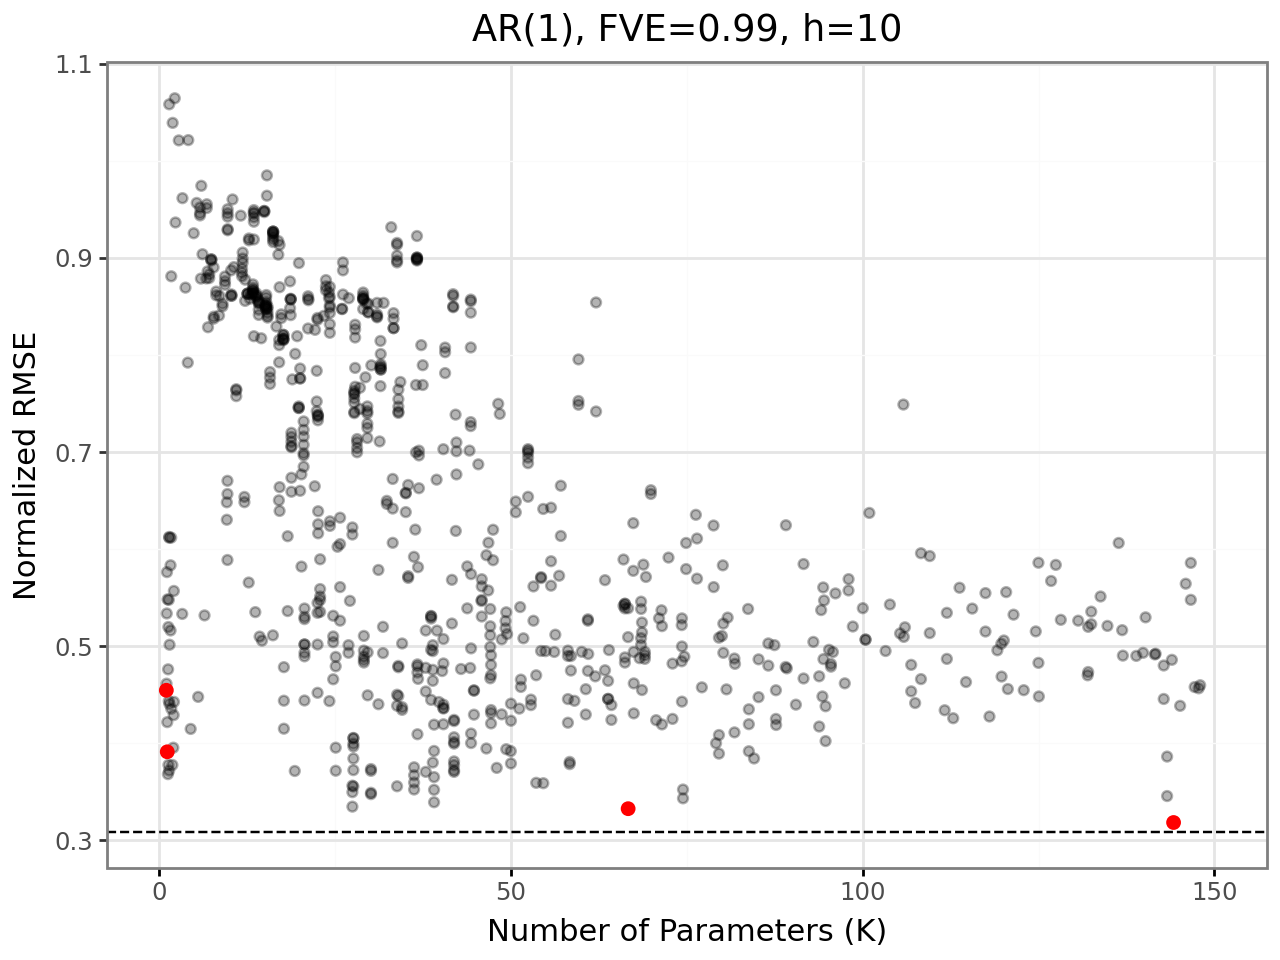

In [64]:
title = "AR(1), FVE=0.99, h=10"
plot, _ = make_pareto_frontier_plot(fve_0_1_df, list([10]), "num_params", title, 0.3, False, True, 0.99)
plot = plot + xlim(0, 150)
plot

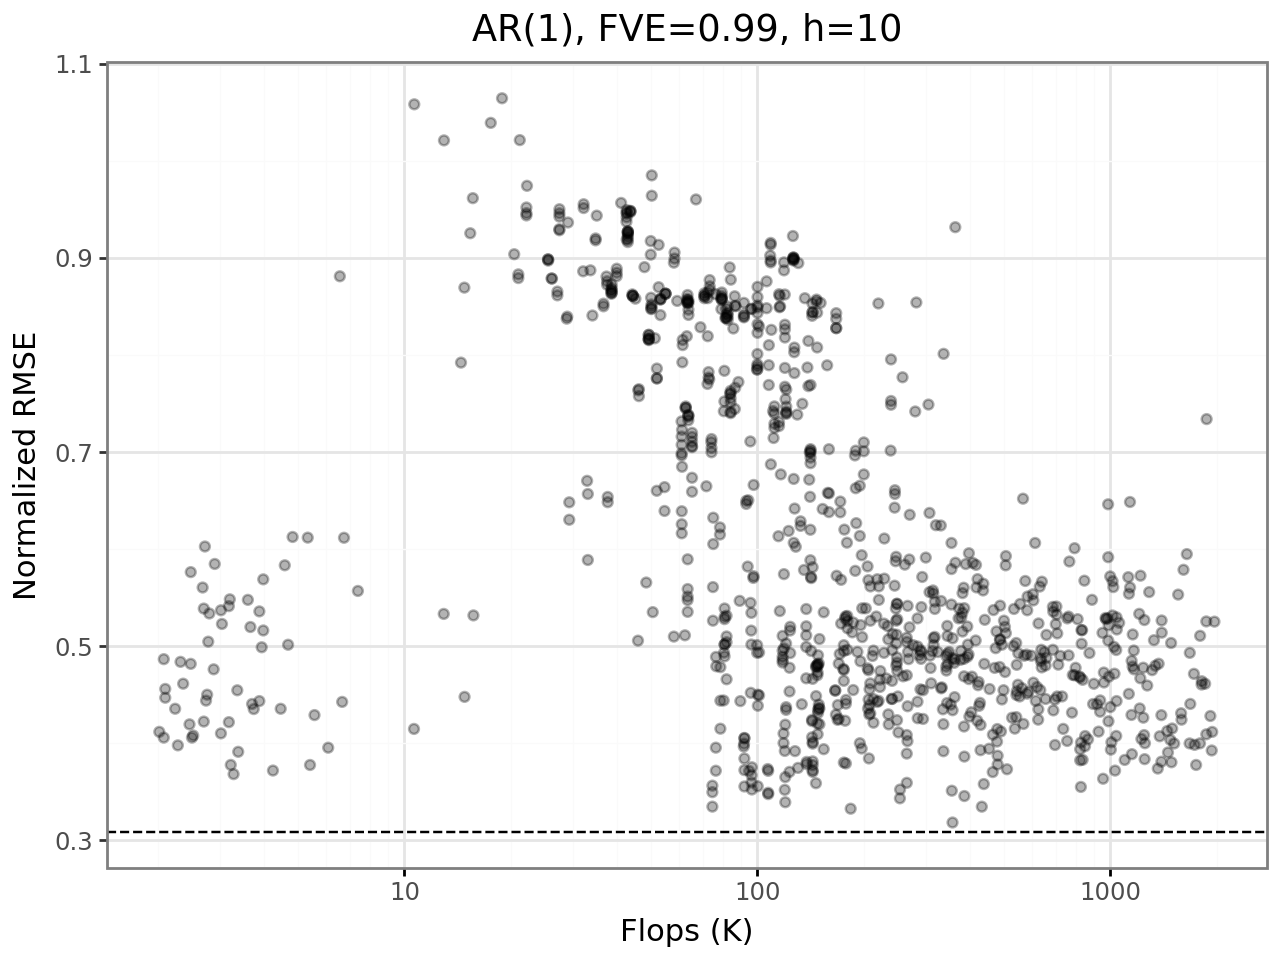

In [34]:
title = "AR(1), FVE=0.99, h=10"
plot, _ = make_pareto_frontier_plot(fve_0_1_df, list([10]), "flops", title, 0.3, True, True, 0.99)
plot